# Capstone Project: Hospital Mortality

**Overview**: The goal of this project is to predict whether or not a patient at a hospital ICU survives. To this end, I develop and validate prediction models for all-cause in-hospital mortality among ICU-admitted patients.

**Dataset**: The dataset used is the MIMIC-III database (https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction) that is a publicly available critical care database containing de-identified data on patient admissions to the ICU of the Beth Israel Deaconess Medical Center, Boston, USA, between 1 June, 2001 and 31 October, 2012.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import category_encoders as ce
from imblearn.over_sampling import SMOTE

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Add dataset from csv
df = pd.read_csv('Data/data01.csv')

In [3]:
# Display head(top 5 rows) of the dataset
df.head()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [4]:
# Examine the dataset information like datatype and non-null counts for different columns. 
# There are 1177 rows and 51 columns in this dataset, with numeric(int or float) type columns
# The target variable is the 'outcome' column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

**Description of features**

Target variable:

Outcome (Alive -0, Died -1)


Predictor variables:

age- Age of the patient (integer)

gendera- Gender of the patient- 1 or 2 (male or female) (integer)

BMI- Body mass index which is a ratio of weight to height squared (float)

hypertensive- whether or not the patient is hypertensive - 0 or 1 (integer)

atrialfibrillation- whether or not the patient has atrial fibrillation (a kind of irregular heart rhythm)- 0 or 1 (integer)

CHD with no MI- whether or not the patient has Corornary Heart Disease without myocardial infarction- 0 or 1 (integer)

diabetes- whether or not the patient has diabetes- 0 or 1 (integer)

deficiencyanemias- whether or not the patient has anemia-related deficiency - 0 or 1 (integer)

depression- whether or not the patient has depression - 0 or 1 (integer)

Hyperlipemia- whether or not the patient has hyperlipidemia (which is high lipid levels in blood)- 0 or 1 (integer)

Renal failure- whether or not the patient has renal/kidney failure - 0 or 1 (integer)

COPD- whether or not the patient has Chronic Obstructive Pulmonary Disease (COPD) - 0 or 1 (integer)

heart rate- heart rate of the patient (integer)

Systolic blood pressure- systolic blood pressure (pressure in arteries when heart beats) (float)

Diastolic blood pressure- diastolic blood pressure (pressure in arteries between the heart beats) (float)

Respiratory rate- respiration rate or breaths per time (float)

temperature- patient's body temperature in Celsius (float)

SP O2- patient's oxygen saturation level (amount of oxygen in hemoglobin) (float)

Urine output- patient's urine output (float)

hematocrit- how much the patient's blood is made up of red blood cells (float)

RBC- Red blood cells (float)

MCH- Mean corpuscular hemoglobin (average amount of hemoglobin in the red blood cells) (float)

MCHC- Mean corpuscular hemoglobun concentration (measure of the concentration of hemoglobin in a given volume of packed red bloods) (float)

MCV- Mean corpuscular volume (average volume of the red blood cells) (float)

RDW- Red cell distribution width (measure of how varies the red blood cells are in size and volume) (float)

Leukocyte- White blood cells count (float)

Platelets- Blood platelet count (float)

Neutrophils- Blood neutrophils (a type of while blood cell/leukocyte) count (float)

Basophils- Blood basophils (a type of white blood cell/leukocyte) count (float)

Lymphocyte- Blood lymphocyte (a type of white blood cell/leukocyte) count (float)

PT- Prothrombin time (PT) test that measures hoow long it takes for a clot to form in the blood (float)

INR- Internation Normalized Ratio (INR) calculated by dividing PT by standard PT (float)

NT-proBNP- B-type Natiuretic peptide (BNP) measurement test value (float)

Creatine kinase- Amount of creatine kinase protein in blood (float)

Creatinine- Amount of creatinine (waste product of creatine kinase) in blood/urine (float)

Urea nitrogen- Amount of urea nitrogen in blood (float)

glucose- Blood glucose (main sugar found in blood) level (float)

Blood potassium- Blood potassium level (float)

Blood sodium- Blood sodium level (float)

Blood calcium- Blood calcium level (float)

Chloride- Blood/serum chloride (electrolyte) level (float)

Anion gap- Difference between negatively and positively charged electrolytes in blood (float)

Magnesium ion- Blood magnesium level (float)

PH- pH level of blood (float)

Bicarbonate- Blood bicarbonate level (float)

Lactic acid- Lactic acid level in blood (float)

PCO2- Partial pressure of CO2 within arterial or venous blood (float)

EF-Ejection fraction (amount of blood that heart pumps each time it beats) (integer)

group                         0
ID                            0
outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophil

<AxesSubplot:>

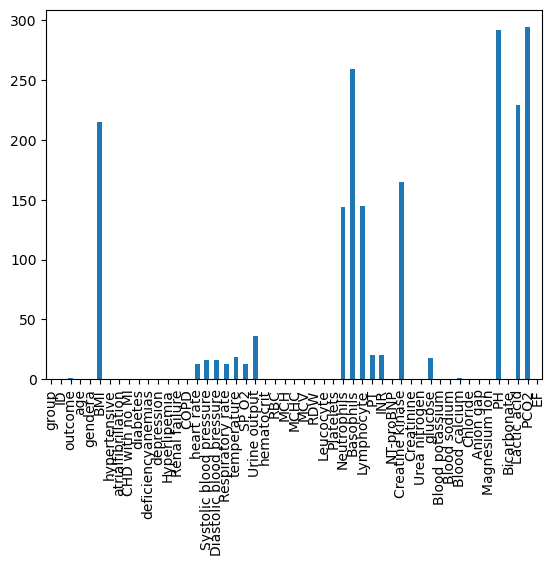

In [5]:
# Show and plot the number of missing values in each column
print(df.isnull().sum())
df.isnull().sum().plot(kind='bar')

In [6]:
#Missing values as a percentage
df.isnull().sum()/(df.shape[0])*100

group                        0.000000
ID                           0.000000
outcome                      0.084962
age                          0.000000
gendera                      0.000000
BMI                         18.266780
hypertensive                 0.000000
atrialfibrillation           0.000000
CHD with no MI               0.000000
diabetes                     0.000000
deficiencyanemias            0.000000
depression                   0.000000
Hyperlipemia                 0.000000
Renal failure                0.000000
COPD                         0.000000
heart rate                   1.104503
Systolic blood pressure      1.359388
Diastolic blood pressure     1.359388
Respiratory rate             1.104503
temperature                  1.614274
SP O2                        1.104503
Urine output                 3.058624
hematocrit                   0.000000
RBC                          0.000000
MCH                          0.000000
MCHC                         0.000000
MCV         

In [7]:
# One outcome value is missing: drop that row
df =df.dropna(subset=['outcome'])

In [8]:
# Does the data have any duplicated values? No.
df.duplicated().sum()

0

0.0    0.864796
1.0    0.135204
Name: outcome, dtype: float64
----------------------------------

------------------Count of patients that survived (0) or died (1) --------------


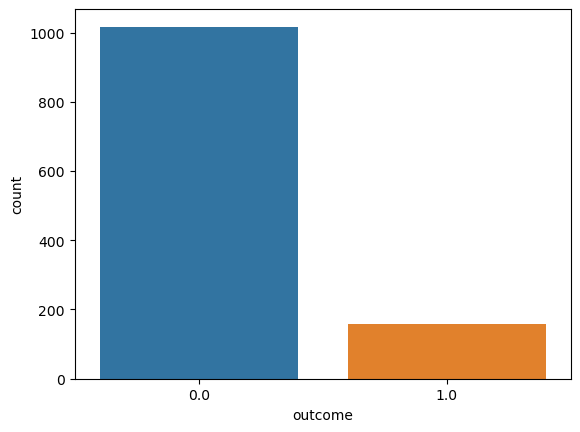

In [9]:
# Plot outcome: survived or not survived
print(df['outcome'].value_counts(normalize=True))
print('----------------------------------\n')
print('------------------Count of patients that survived (0) or died (1) --------------')
sns.countplot(df['outcome'])
plt.show()
#plt.title('Count of patients that survived (0) or nor (1)')

# The data is imbalanced as there are about 86.5 % of survivors and 13.5% non-survivors

['group', 'ID', 'age', 'gendera', 'BMI', 'hypertensive', 'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2', 'Urine output', 'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte', 'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR', 'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen', 'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium', 'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'Lactic acid', 'PCO2', 'EF']


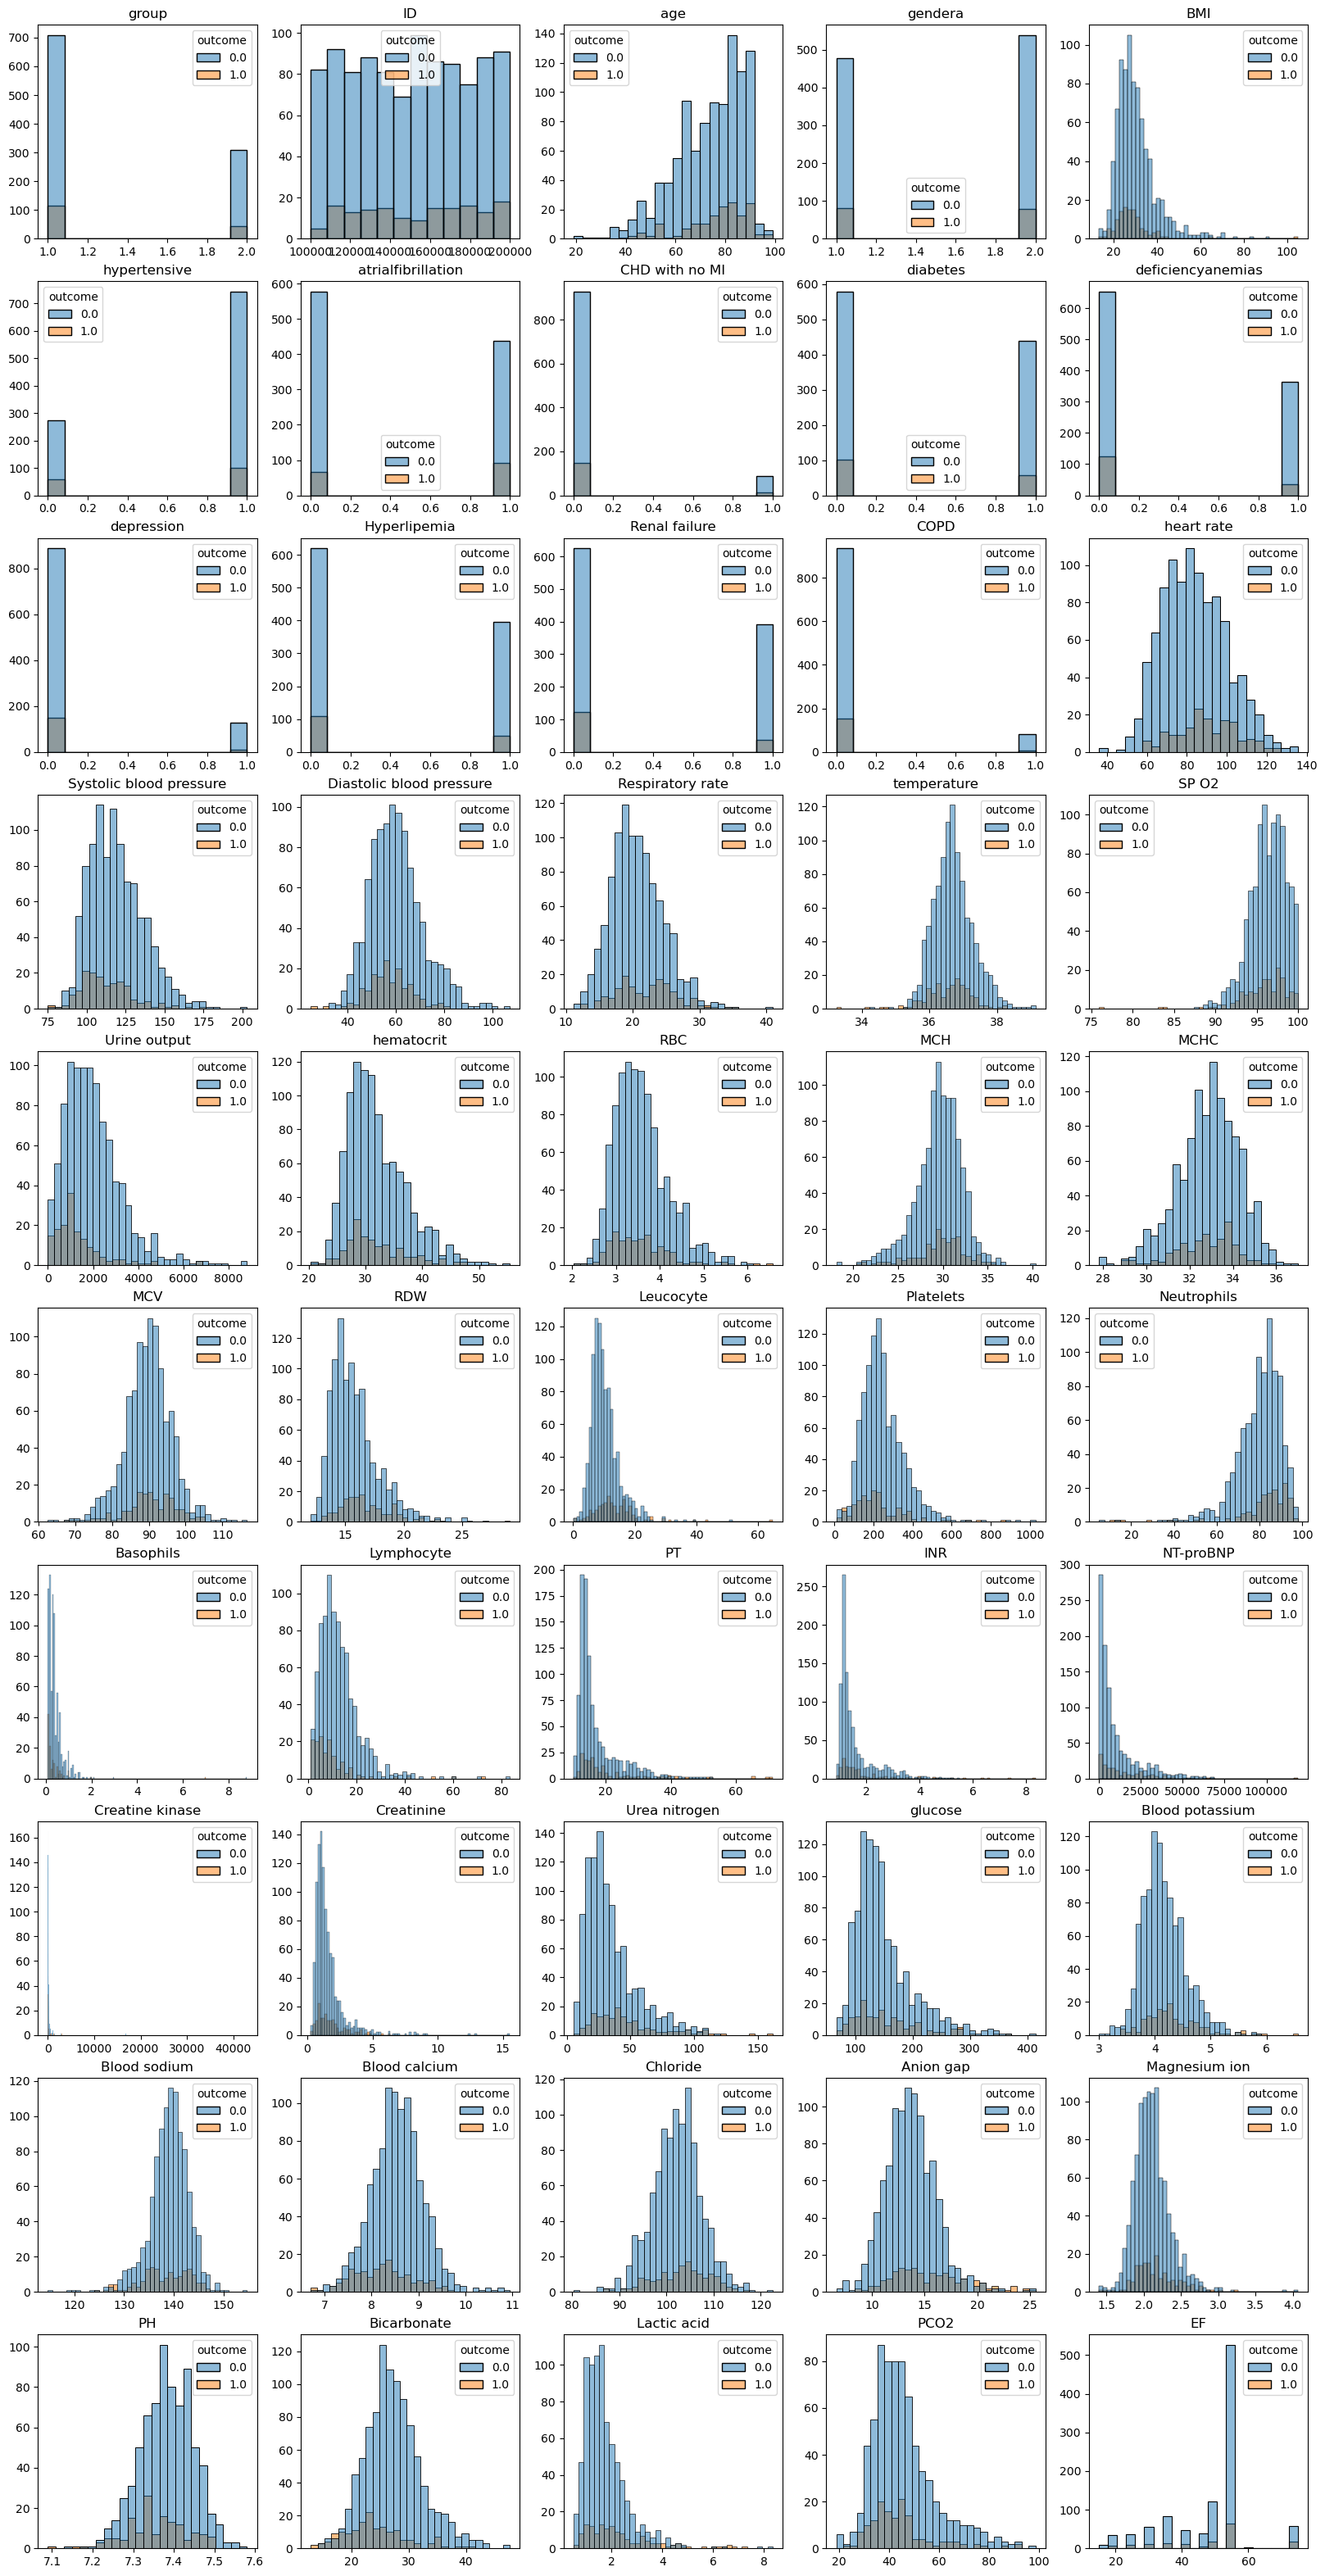

In [10]:
# Plotting histogram distributions of all the variables colored by the target variable
predictors = list(df.columns)
#print(predictors)
predictors.remove('outcome')
print(predictors)

fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20,40))
axes = axes.flatten()

for idx, axis in enumerate(axes):
    sns.histplot(data=df, x=df[predictors].iloc[:, idx],
                 ax=axis, hue=df['outcome'], legend=True)
    axis.set_ylabel('')    
    axis.set_xlabel('')
    axis.set_title(predictors[idx])

In [11]:
# Some variables like age, bmi, atrialfibrillation, platelets, blood potassium, anion gap, bicarbonate, and 
# lactic acid do seem to show some differences in distributions in the plots above that care colored by the outcome

In [12]:
# Useless columns that cannot be used as predictors are removed
df=df.drop(['group','ID'],axis=1)
#df.head()

In [13]:
# Correcting the spelling of gender column
df['gender']=df['gendera']
df=df.drop(['gendera'],axis=1)
df.head()

,outcome,age,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,...,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,gender
0,0.0,72,37.588179,0,0,0,1,1,0,1,...,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55,1
1,0.0,75,NaN,0,0,0,0,1,0,0,...,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55,2
2,0.0,83,26.572634,0,0,0,0,1,0,0,...,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35,2
3,0.0,43,83.264629,0,0,0,0,0,0,0,...,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55,2
4,0.0,75,31.824842,1,0,0,0,1,0,0,...,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55,2


Text(0.5, 1.0, 'Heatmap of correlations')

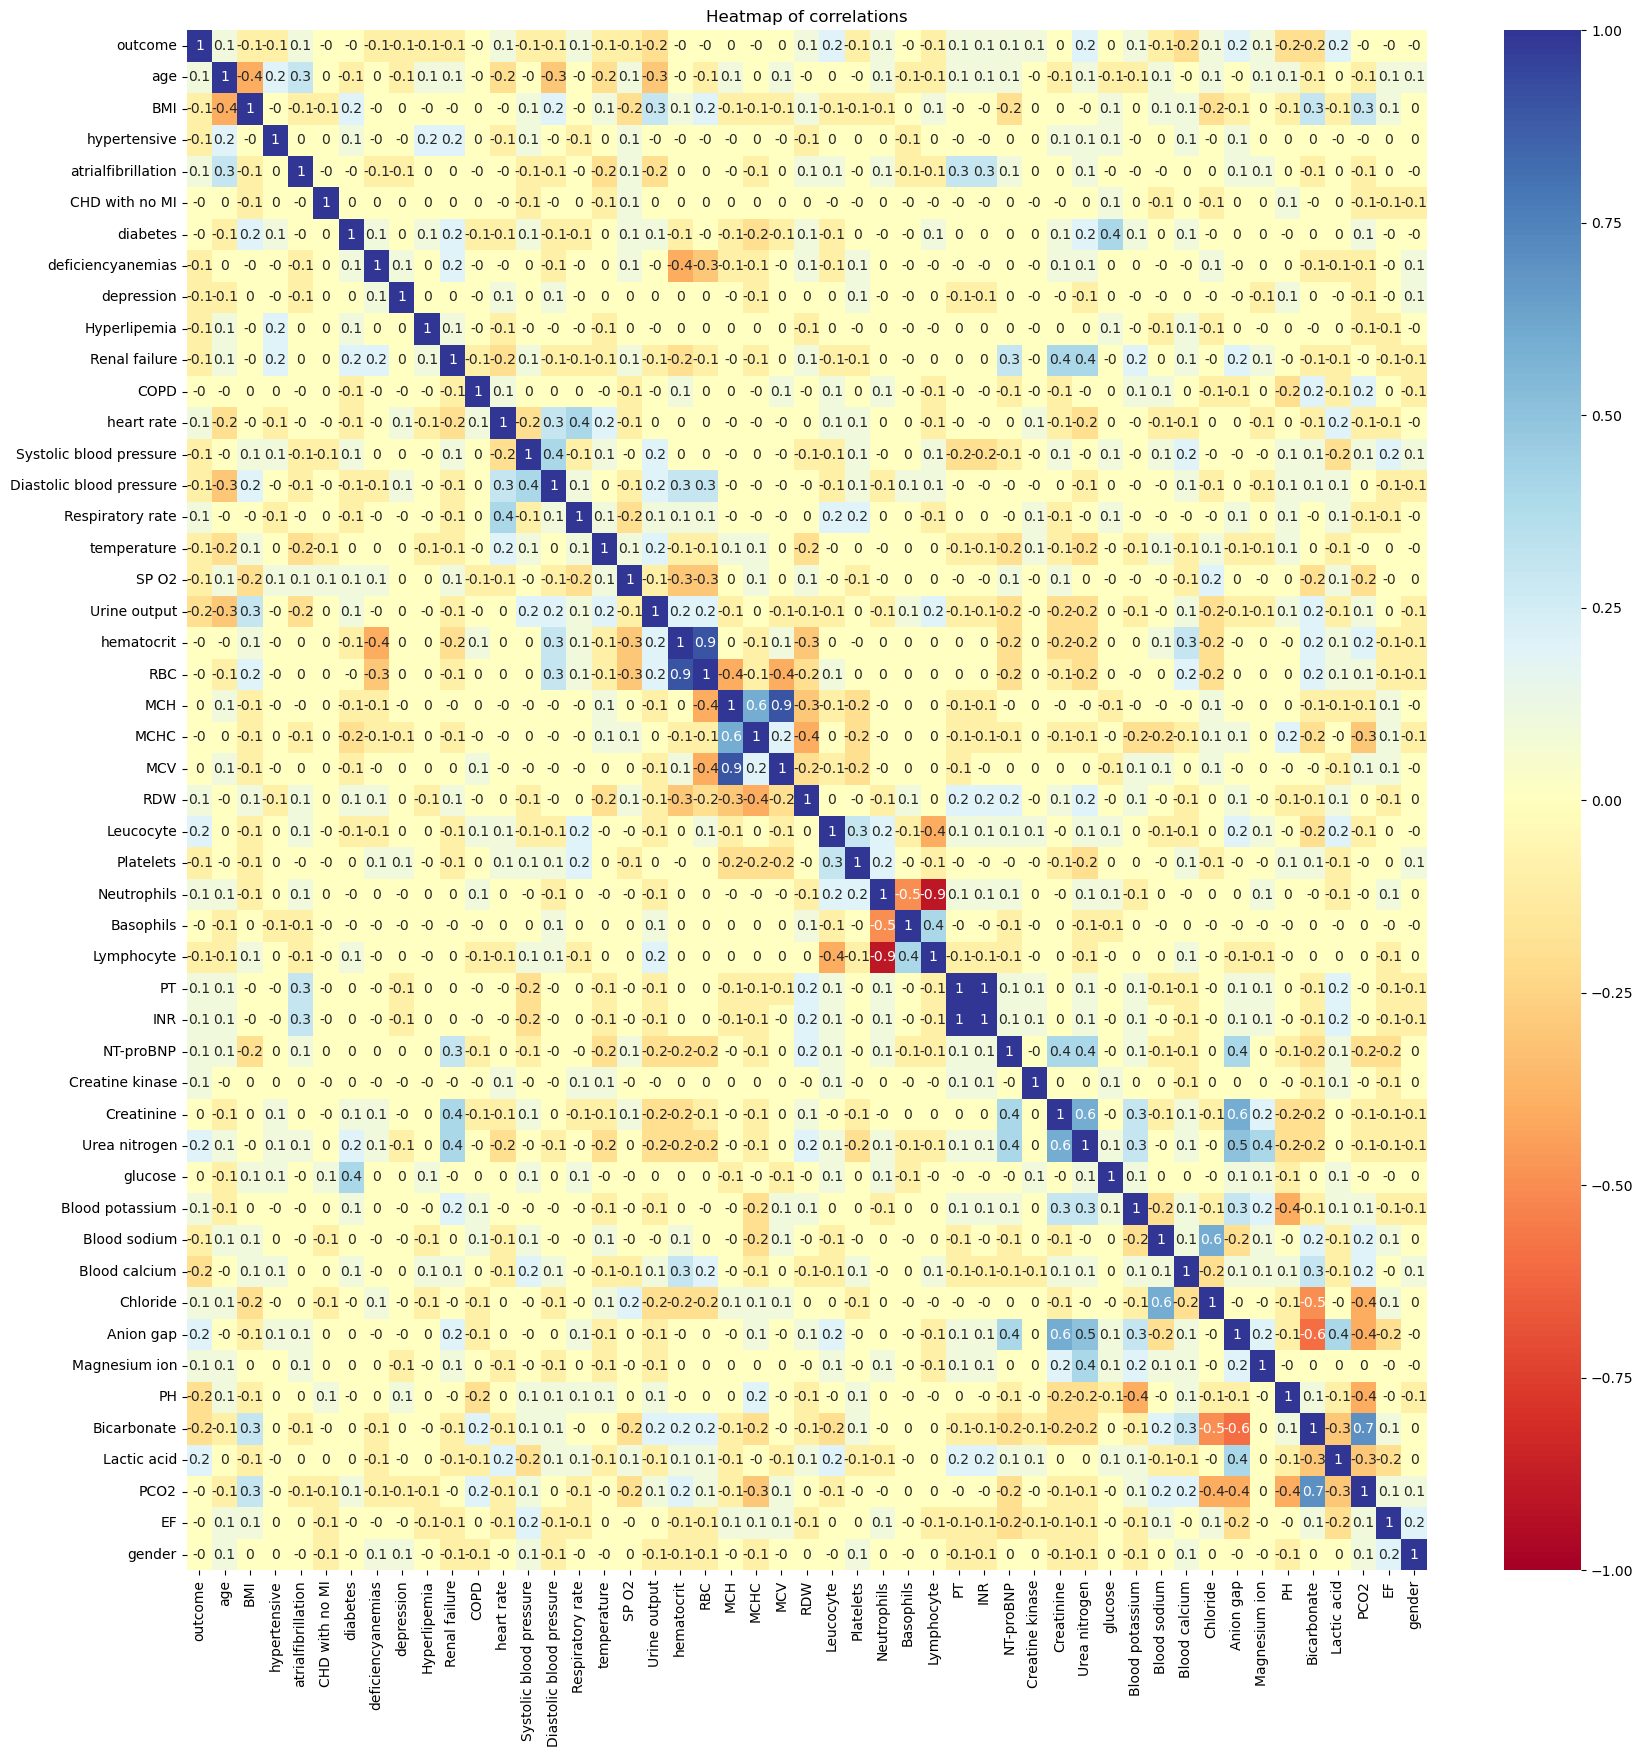

In [14]:
# Correlation heatmap to visualize correlation of variables with the target variable as well as to detect multicollinearity
plt.figure(figsize=(20,20))
sns.heatmap(round(df.corr(),1),vmin=-1,vmax=1,annot=True,cmap='RdYlBu')
plt.title('Heatmap of correlations')

The outcome does not seem to be highly correlated with any of the variables
There are some high correlations amongst the variables like PT and INR; 
MCH and MCV; hematocrit and RBC; and Lymphocytes and Neutrophils. One variable in each of these pairs of multicollinear variables are removed.

In [15]:
#Remove highly correlated variables to remove multicillinearilty
df=df.drop(columns=['INR','MCH','RBC','Neutrophils'])
df.head()

,outcome,age,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,...,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,gender
0,0.0,72,37.588179,0,0,0,1,1,0,1,...,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55,1
1,0.0,75,NaN,0,0,0,0,1,0,0,...,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55,2
2,0.0,83,26.572634,0,0,0,0,1,0,0,...,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35,2
3,0.0,43,83.264629,0,0,0,0,0,0,0,...,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55,2
4,0.0,75,31.824842,1,0,0,0,1,0,0,...,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55,2


In [16]:
# Divide the dataset into X(predictors) and y(target)
X = df.iloc[:, 1:]
y=df['outcome']
print(X.columns)

Index(['age', 'BMI', 'hypertensive', 'atrialfibrillation', 'CHD with no MI',
       'diabetes', 'deficiencyanemias', 'depression', 'Hyperlipemia',
       'Renal failure', 'COPD', 'heart rate', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Respiratory rate', 'temperature', 'SP O2',
       'Urine output', 'hematocrit', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Basophils', 'Lymphocyte', 'PT', 'NT-proBNP',
       'Creatine kinase', 'Creatinine', 'Urea nitrogen', 'glucose',
       'Blood potassium', 'Blood sodium', 'Blood calcium', 'Chloride',
       'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate', 'Lactic acid',
       'PCO2', 'EF', 'gender'],
      dtype='object')


In [17]:
# Creating train and test data
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y.values, test_size=0.25, random_state = 42)
X_tr

,age,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,...,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,gender
669,79,26.653279,1,1,0,1,0,1,0,0,...,7.790000,102.000000,15.818182,2.158333,7.327857,25.909091,6.777778,45.307692,55,2
640,72,26.262626,1,0,0,0,0,0,0,0,...,8.088889,92.214286,18.769231,2.580000,7.325714,18.071429,3.800000,43.571429,55,2
190,64,42.006173,0,0,0,1,0,1,0,0,...,8.760000,98.000000,11.375000,2.000000,7.368333,32.875000,1.250000,60.833333,55,1
961,86,20.415225,1,1,0,0,0,0,0,1,...,8.428571,101.000000,13.500000,2.050000,7.550000,24.750000,1.650000,28.000000,55,1
68,56,49.549571,1,1,0,0,1,0,0,1,...,8.775000,98.812500,13.812500,2.561538,7.215000,28.411765,0.960000,88.250000,35,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,63,13.673625,1,1,0,0,0,1,1,0,...,9.337500,100.125000,12.000000,1.862500,7.320000,31.500000,1.200000,67.500000,50,2
972,89,25.312500,0,0,1,1,1,0,1,1,...,9.655556,99.916667,15.500000,2.133333,NaN,28.416667,1.700000,NaN,50,1
808,75,24.445850,1,1,0,1,1,0,1,1,...,7.681818,101.363636,14.727273,2.325000,NaN,26.909091,NaN,NaN,55,2
859,58,56.132848,1,1,0,1,1,0,1,0,...,8.777778,95.416667,11.916667,2.170000,7.365000,37.000000,1.025000,70.666667,55,1


In [18]:
# Impute data to eliminate NaN values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")

# Impute training set
X_tr_impute = imputer.fit_transform(X_tr)
X_tr_impute

array([[79.        , 26.65327911,  1.        , ..., 45.30769231,
        55.        ,  2.        ],
       [72.        , 26.26262626,  1.        , ..., 43.57142857,
        55.        ,  2.        ],
       [64.        , 42.00617284,  0.        , ..., 60.83333333,
        55.        ,  1.        ],
       ...,
       [75.        , 24.44584967,  1.        , ..., 42.75      ,
        55.        ,  2.        ],
       [58.        , 56.13284774,  1.        , ..., 70.66666667,
        55.        ,  1.        ],
       [75.        , 25.78014999,  1.        , ..., 49.2       ,
        35.        ,  2.        ]])

In [19]:
# Impute test set separately
X_te_impute = imputer.transform(X_te)
X_te_impute

array([[77.        , 23.17057857,  1.        , ..., 48.        ,
        20.        ,  2.        ],
       [85.        , 30.10380623,  0.        , ..., 66.        ,
        15.        ,  2.        ],
       [81.        , 22.20134073,  1.        , ..., 43.        ,
        55.        ,  2.        ],
       ...,
       [76.        , 22.650587  ,  1.        , ..., 55.        ,
        75.        ,  2.        ],
       [65.        , 26.40955005,  1.        , ..., 46.77      ,
        40.        ,  1.        ],
       [84.        , 30.56950558,  0.        , ..., 40.30769231,
        55.        ,  2.        ]])

In [20]:
# Balance the dataset using the SMOTE oversampler
oversampler=SMOTE(random_state=42)
X_tr_bal,y_tr_bal=oversampler.fit_resample(X_tr_impute,y_tr)
X_tr_bal

array([[79.        , 26.65327911,  1.        , ..., 45.30769231,
        55.        ,  2.        ],
       [72.        , 26.26262626,  1.        , ..., 43.57142857,
        55.        ,  2.        ],
       [64.        , 42.00617284,  0.        , ..., 60.83333333,
        55.        ,  1.        ],
       ...,
       [64.47883762, 22.62013038,  0.        , ..., 48.19654067,
        70.19841494,  2.        ],
       [70.9129112 , 42.785207  ,  0.77282278, ..., 40.29026761,
        67.0487973 ,  1.        ],
       [90.15957054, 20.07846673,  1.        , ..., 37.55953585,
        44.20214732,  1.        ]])

In [21]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_tr_bal)
y_train=y_tr_bal
X_test=scaler.transform(X_te_impute)
X_test
y_test=y_te

In [22]:
X_train=pd.DataFrame(X_train,columns=X_tr.columns)
X_train

,age,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,...,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,gender
0,0.314597,-0.282479,0.812075,1.043123,-0.321204,1.396428,-0.660739,3.018919,-0.754627,-0.683899,...,-1.043444,-0.152837,0.445891,0.076980,-0.645955,0.046265,4.297186,-0.017862,0.508547,1.050380
1,-0.239363,-0.332385,0.812075,-1.095426,-0.321204,-0.824020,-0.660739,-0.378973,-0.754627,-0.683899,...,-0.511715,-2.088037,1.465911,1.693475,-0.679586,-1.487897,1.584021,-0.171108,0.508547,1.050380
2,-0.872461,1.678856,-1.478099,-1.095426,-0.321204,1.396428,-0.660739,3.018919,-0.754627,-0.683899,...,0.682206,-0.943867,-1.089879,-0.530004,-0.010688,1.409788,-0.739380,1.352462,0.508547,-1.117738
3,0.868558,-1.079392,0.812075,1.043123,-0.321204,-0.824020,-0.660739,-0.378973,-0.754627,1.650496,...,0.092588,-0.350594,-0.355380,-0.338325,2.840537,-0.180618,-0.374925,-1.545472,0.508547,-1.117738
4,-1.505558,2.642527,0.812075,1.043123,-0.321204,-0.824020,1.716886,-0.378973,-0.754627,1.650496,...,0.708891,-0.783189,-0.247366,1.622701,-2.417227,0.536144,-1.003610,3.772310,-1.134511,-1.117738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,-0.215028,0.138838,-1.079427,1.043123,-0.321204,1.009894,-0.660739,-0.378973,-0.357643,-0.277529,...,0.092997,0.499141,0.867264,0.573152,-0.497969,-1.202428,0.208285,-1.239412,-1.598513,-1.117738
1522,0.846232,-0.367912,-0.794769,0.405035,-0.321204,-0.824020,1.716886,2.005075,-0.754627,-0.683899,...,-1.311523,0.439133,-0.161570,1.344739,-0.017276,-0.219619,-0.136256,-0.248421,0.140862,0.403469
1523,-0.834567,-0.797715,-1.478099,-1.095426,-0.321204,-0.824020,-0.660739,-0.378973,-0.754627,-0.683899,...,-1.072624,0.351393,-0.647991,-0.143045,-1.446608,-0.613217,0.825347,0.237114,1.757141,1.050380
1524,-0.325392,1.778378,0.291800,-1.095426,-0.321204,-0.824020,-0.660739,-0.378973,-0.754627,-0.683899,...,-0.362874,0.053242,-0.385301,0.576416,1.364058,-0.052682,-0.092628,-0.460709,1.498391,-1.117738


In [23]:
X_train.shape

(1526, 44)

In [24]:
y_train.shape

(1526,)

In [25]:
X_test=pd.DataFrame(X_test,columns=X_te.columns)
X_test

,age,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,...,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,gender
0,0.156323,-0.727395,0.812075,-1.095426,3.557617,1.396428,1.716886,-0.378973,-0.754627,-0.683899,...,-1.766912,-0.760235,-0.997295,1.003430,-0.612323,-0.257517,-0.633080,0.219767,-2.366805,1.050380
1,0.789420,0.158327,-1.478099,1.043123,-0.321204,-0.824020,1.716886,-0.378973,-0.754627,1.650496,...,1.820779,-0.073734,-1.288626,1.616804,-0.769271,1.982334,-0.784937,1.808482,-2.777570,1.050380
2,0.472872,-0.851215,0.812075,1.043123,-0.321204,1.396428,-0.660739,-0.378973,-0.754627,1.650496,...,0.270490,0.088867,-0.912255,1.660616,-0.141478,0.477293,0.171758,-0.221543,0.508547,1.050380
3,-0.001952,-0.620757,-1.478099,-1.095426,-0.321204,-0.824020,1.716886,-0.378973,-0.754627,-0.683899,...,-0.380759,-0.855975,-1.065876,-0.961283,-2.260279,1.521252,-1.422733,2.867625,0.508547,1.050380
4,-0.635049,0.715616,0.812075,-1.095426,-0.321204,-0.824020,-0.660739,3.018919,-0.754627,-0.683899,...,-0.723220,0.522836,-0.151134,-0.434165,0.172418,-0.149478,-0.466038,-0.721694,-0.312982,1.050380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.472872,0.155656,0.812075,-1.095426,-0.321204,1.396428,-0.660739,-0.378973,1.525851,-0.683899,...,1.795364,-1.763149,-1.713277,-0.146646,0.196564,3.279826,-0.906422,2.643576,0.508547,1.050380
290,1.105969,-0.235746,0.812075,1.043123,-0.321204,1.396428,1.716886,-0.378973,1.525851,1.650496,...,-0.478263,-0.365806,2.104028,-0.588982,-1.251326,-1.426593,1.024914,-0.729049,0.508547,1.050380
291,0.077186,-0.793824,0.812075,-1.095426,-0.321204,-0.824020,-0.660739,-0.378973,1.525851,-0.683899,...,0.397562,0.129674,-0.775094,-1.132425,-1.397064,0.567397,-0.511595,0.837600,2.151606,1.050380
292,-0.793324,-0.313615,0.812075,-1.095426,-0.321204,-0.824020,-0.660739,3.018919,1.525851,-0.683899,...,-0.136144,-1.141625,-1.703402,-0.146646,-1.318590,1.512552,0.217315,0.111205,-0.723747,-1.117738


In [26]:
X_test.shape

(294, 44)

In [27]:
y_test.shape

(294,)

#  Modeling

First a baseline model is run using the Dummy Classifier. Additionally, common classifier models like Logistic Regression, K Nearest Neighbor (KNN), Decision Trees, Support Vector Machines (SVM), Random Forest, AdaBoost Classifier and a neural network model are fit and cross-validated using the test-set.

Confusion matrix is plotted, and classification reports showing different scores like Precision, Recall, F-1 are shown.

For the critical life-saving decisions of ICU patients, it is important to minimize false negatives, so Recall is a crucial metric in this exercise. Train and Test recall scores are printed for all the models.

0.002689361572265625


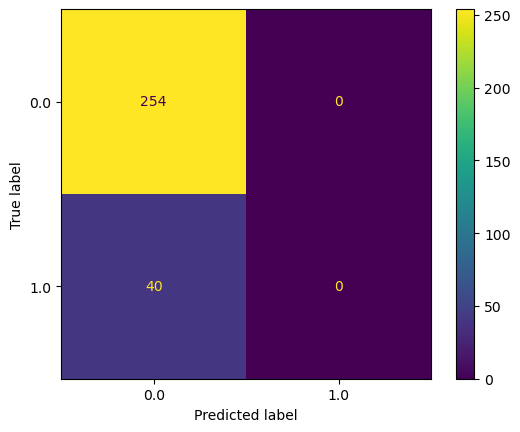

Train and test Recall score
0.0
0.0
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       254
         1.0       0.00      0.00      0.00        40

    accuracy                           0.86       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.86      0.80       294



In [28]:
# Dummy Classifier
start=time.time()
dummy=DummyClassifier(random_state=42).fit(X_train,y_train)
end=time.time()
dummy_time=end-start
print(dummy_time)

ConfusionMatrixDisplay.from_estimator(dummy, X_test, y_test)
plt.show()

print('Train and test Recall score')
dummy_train_recall=recall_score(y_train,dummy.predict(X_train))
print(dummy_train_recall)
dummy_test_recall=recall_score(y_test,dummy.predict(X_test))
print(dummy_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,dummy.predict(X_test)))
# Test recall is 0%

0.05876326560974121


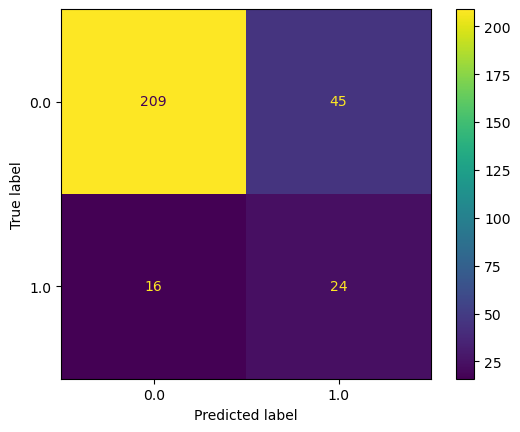

Train and test Recall score
0.8348623853211009
0.6
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       254
         1.0       0.35      0.60      0.44        40

    accuracy                           0.79       294
   macro avg       0.64      0.71      0.66       294
weighted avg       0.85      0.79      0.81       294



In [29]:
# Logistic Regression
start=time.time()
log=LogisticRegression(random_state=42).fit(X_train,y_train)
end=time.time()
log_time=end-start
print(log_time)

ConfusionMatrixDisplay.from_estimator(log, X_test, y_test)
plt.show()

print('Train and test Recall score')
log_train_recall=recall_score(y_train,log.predict(X_train))
print(log_train_recall)
log_test_recall=recall_score(y_test,log.predict(X_test))
print(log_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,log.predict(X_test)))

# Test recall is 60%
# Note that changing probability decision thresholds was tried for all models but not eventually kept in the final notebook 
# because it increased recall but decreased precision

0.0029621124267578125


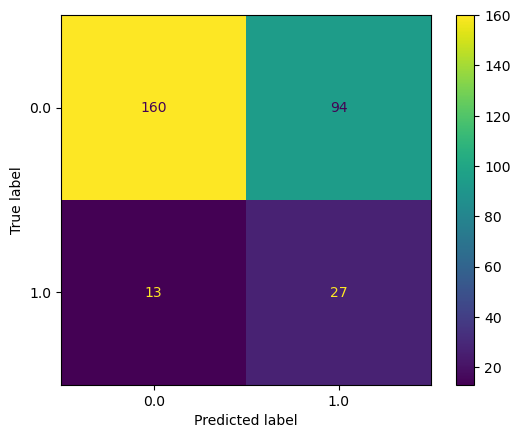

Train and test Recall score
1.0
0.675
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.92      0.63      0.75       254
         1.0       0.22      0.68      0.34        40

    accuracy                           0.64       294
   macro avg       0.57      0.65      0.54       294
weighted avg       0.83      0.64      0.69       294



In [35]:
# K Nearest Neighbors (KNN)
start=time.time()
knn=KNeighborsClassifier().fit(X_train,y_train)
end=time.time()
knn_time=end-start
print(knn_time)

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.show()

print('Train and test Recall score')
knn_train_recall=recall_score(y_train,knn.predict(X_train))
print(knn_train_recall)
knn_test_recall=recall_score(y_test,knn.predict(X_test))
print(knn_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,knn.predict(X_test)))

# Test recall is 67%

0.07425308227539062


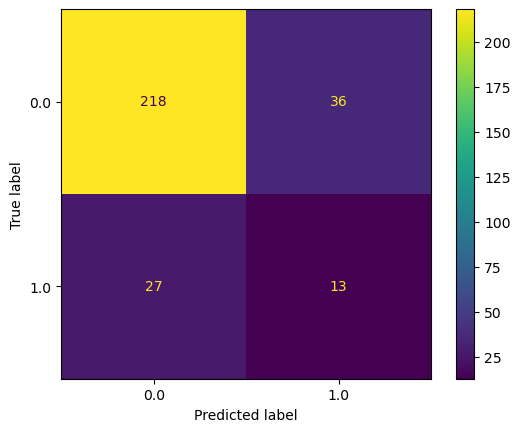

Train and test Recall score
1.0
0.325
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       254
         1.0       0.27      0.33      0.29        40

    accuracy                           0.79       294
   macro avg       0.58      0.59      0.58       294
weighted avg       0.80      0.79      0.79       294



In [36]:
# Decision Tree
start=time.time()
tree=DecisionTreeClassifier(random_state=42).fit(X_train,y_train)
end=time.time()
tree_time=end-start
print(tree_time)

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)
plt.show()

print('Train and test Recall score')
tree_train_recall=recall_score(y_train,tree.predict(X_train))
print(tree_train_recall)
tree_test_recall=recall_score(y_test,tree.predict(X_test))
print(tree_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,tree.predict(X_test)))

# Test recall is 33%

0.8477611541748047


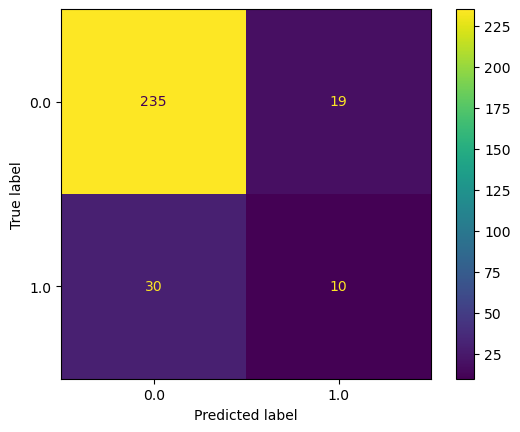

Train and test Recall score
0.9908256880733946
0.25
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       254
         1.0       0.34      0.25      0.29        40

    accuracy                           0.83       294
   macro avg       0.62      0.59      0.60       294
weighted avg       0.81      0.83      0.82       294



In [37]:
# Support Vector Machines (SVM)
start=time.time()
svm=SVC(random_state=42, probability=True).fit(X_train,y_train)
end=time.time()
svm_time=end-start
print(svm_time)

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)
plt.show()

print('Train and test Recall score')
svm_train_recall=recall_score(y_train,svm.predict(X_train))
print(svm_train_recall)
svm_test_recall=recall_score(y_test,svm.predict(X_test))
print(svm_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,svm.predict(X_test)))

# Test recall is 25%

0.7912783622741699


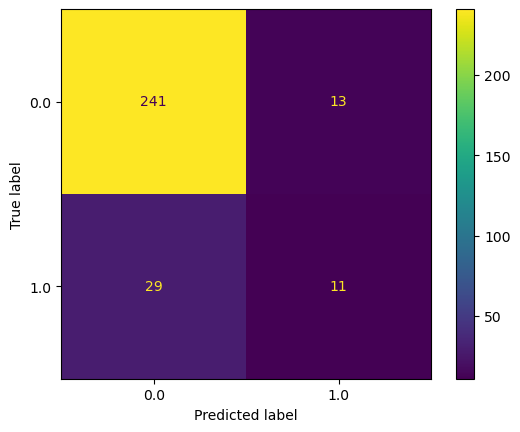

Train and test Recall score
1.0
0.275
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       254
         1.0       0.46      0.28      0.34        40

    accuracy                           0.86       294
   macro avg       0.68      0.61      0.63       294
weighted avg       0.83      0.86      0.84       294



In [38]:
# Random Forests
start=time.time()
rf=RandomForestClassifier(random_state=42).fit(X_train,y_train)
end=time.time()
rf_time=end-start
print(rf_time)

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()

print('Train and test Recall score')
rf_train_recall=recall_score(y_train,rf.predict(X_train))
print(rf_train_recall)
rf_test_recall=recall_score(y_test,rf.predict(X_test))
print(rf_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,rf.predict(X_test)))

#Test recall is 28%

0.6164557933807373


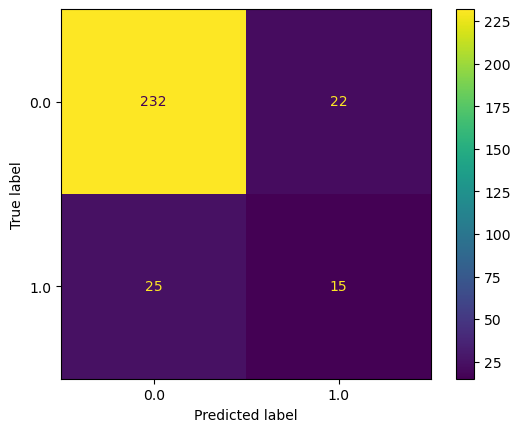

Train and test Recall score
0.9423328964613368
0.375
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       254
         1.0       0.41      0.38      0.39        40

    accuracy                           0.84       294
   macro avg       0.65      0.64      0.65       294
weighted avg       0.84      0.84      0.84       294



In [39]:
# AdaBoost Classifier
start=time.time()
ad=AdaBoostClassifier(random_state=42).fit(X_train,y_train)
end=time.time()
rf_time=end-start
print(rf_time)

ConfusionMatrixDisplay.from_estimator(ad, X_test, y_test)
plt.show()

print('Train and test Recall score')
ad_train_recall=recall_score(y_train,ad.predict(X_train))
print(ad_train_recall)
ad_test_recall=recall_score(y_test,ad.predict(X_test))
print(ad_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,ad.predict(X_test)))

# Test recall is 38%

Lazypredict package can run sevel ML models in a few lines of code. So instead of additional running models manually, 
lazypredict classifier is fit and scored for scores like accuracy, Recall, ROC AUC, and F1. This is quick and easy for a quick preview, but the cons of this are that lack of transparency in what is happening behind and inability to check and tweak models.

In [40]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [41]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=recall_score)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:06<00:00,  4.65it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,recall_score,Time Taken
Model,,,,,,
LinearSVC,0.79,0.72,0.72,0.81,0.62,0.29
LinearDiscriminantAnalysis,0.78,0.72,0.72,0.81,0.62,0.09
NearestCentroid,0.78,0.71,0.71,0.80,0.62,0.03
LogisticRegression,0.79,0.71,0.71,0.81,0.60,0.05
RidgeClassifier,0.78,0.71,0.71,0.81,0.60,0.03
RidgeClassifierCV,0.78,0.70,0.70,0.80,0.60,0.03
CalibratedClassifierCV,0.79,0.70,0.70,0.81,0.57,1.11
BernoulliNB,0.76,0.68,0.68,0.79,0.57,0.03
GaussianNB,0.74,0.67,0.67,0.78,0.57,0.02


It is hard to determine the best model with different important metrics like Recall, ROC AUC, and F-1 score.

While a high recall is crucial to minimize false negatives of wrongly identifying patients who are critical/ will die as survivors, but it may also be important to also have a higher F-1 score and ROC AUC for a better performing model so that overall scores are high in different aspects and less time/energy/money is wasted on false positives. So it maybe important to pick a model by compromise such that all score are generally high.

Models with high recall (>0.6) and a reasonably high ROC AUC and F-1 scores are **Logistic Regression** (shown above) and  **Ridge Classifier** (implemented below).


*Note: One thing I noticed is that the lazy predict models have predicted higher F-1 scores compared to my models, as my F-1 scores for class 1 are usually around 0.40. Not sure why as the models in lazypredict are not gridsearched for hyperparamter tuning either.The Recall and ROC AUC scores are similar for lazypredict and my models. Code and method behind lazypredict is not transparent, so I will stick to the interpretation of my models ran in this notebook*

0.0


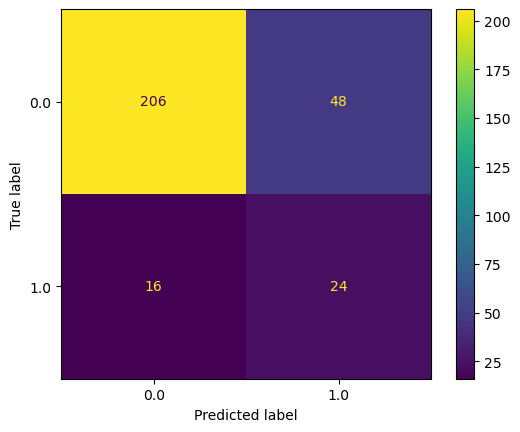

Train and test Recall score
0.8401048492791612
0.6
------------Classification Report-------------
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87       254
         1.0       0.33      0.60      0.43        40

    accuracy                           0.78       294
   macro avg       0.63      0.71      0.65       294
weighted avg       0.85      0.78      0.81       294



In [42]:
# Ridge Classfier
start=time.time()
rc=RidgeClassifier(random_state=42).fit(X_train,y_train)
end=time.time()
rc_time=end-start
print(rc_time)

ConfusionMatrixDisplay.from_estimator(rc, X_test, y_test)
plt.show()

print('Train and test Recall score')
rc_train_recall=recall_score(y_train,rc.predict(X_train))
print(rc_train_recall)
rc_test_recall=recall_score(y_test,rc.predict(X_test))
print(rc_test_recall)
print('------------Classification Report-------------')
print(classification_report(y_test,rc.predict(X_test)))

# One of the best performing model w/ high Recall of 60% along with F-1 score 43%.logistic reg performance is similar.

In [43]:
#%%time
# Lastly,a Neural Network model is also implemented
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
tf.random.set_seed(42)

nn1=Sequential()
nn1.add(Dense(100,activation='relu'))
nn1.add(Dense(40,activation='relu'))
nn1.add(Dense(1,activation='sigmoid'))

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


nn1.compile(loss='bce',metrics=['acc',f1_m,precision_m, recall_m])
history1=nn1.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=30,verbose=0)

print(history1.history['val_recall_m'][-1])
# Recall of the neural network model is only 37%,lower than Logistic, KNN, and Ridge classifiers

0.3683333396911621


In [44]:
nn1.evaluate(X_test,y_test)
# F-1 score of neural network model is 35%.

10/10 [==============================] - 0s 3ms/step - loss: 1.8060 - acc: 0.8197 - f1_m: 0.3481 - precision_m: 0.4667 - recall_m: 0.3683        


[1.8060022592544556,
 0.819727897644043,
 0.34805190563201904,
 0.46666663885116577,
 0.3683333396911621]

In [45]:
y_pred = nn1.predict(X_test)
y_pred =(y_pred>0.5)
list(y_pred)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cm)

10/10 [==============================] - 0s 2ms/step
Confusion matrix
[[229  25]
 [ 28  12]]


In [46]:
# Dataframe containing scores and times for all the classifiers/models I ran

all1 = {'My Models': [ 'Dummy', 'Logistic Regression', 'KNN','Decision Tree', 'SVM', 'Random Forest', 'AdaBoost','Ridge Classifier', 'Neural Network'],\
        'Test accuracy': [0.86,0.79,0.64,0.79,0.83,0.86,0.84,0.78,0.82],\
        'Test Recall score': [0,0.60,0.67,0.32,0.25,0.28,0.38,0.60,0.37],\
        'Test F1 score': [0,0.44,0.34,0.29,0.29,0.34,0.39,0.43,0.35],\
       'Time': [0.003,0.06,0.003,0.07,0.9,0.8,0.6,0.001,7]}
df1 = pd.DataFrame(all1).set_index('My Models')
pd.set_option('max_colwidth', None)
df1

# Logisitc, KNN, and Ridge classifiers have the highest recall scores(>60%), 
# but only the Ridge and Logistic have highest F1 scores (~45%)

,Test accuracy,Test Recall score,Test F1 score,Time
My Models,,,,
Dummy,0.86,0.00,0.00,0.00
Logistic Regression,0.79,0.60,0.44,0.06
KNN,0.64,0.67,0.34,0.00
Decision Tree,0.79,0.32,0.29,0.07
SVM,0.83,0.25,0.29,0.90
Random Forest,0.86,0.28,0.34,0.80
AdaBoost,0.84,0.38,0.39,0.60
Ridge Classifier,0.78,0.60,0.43,0.00
Neural Network,0.82,0.37,0.35,7.00


 **Gridsearching Hyperparameters**

This is done for the two models that are performing best overall....i.e, Ridge regression and Logistic regression which have a recall higher than or equal to 60% and F-1 scores of higher than 40% in models that I ran.

Fitting 5 folds for each of 30 candidates, totalling 150 fits
-----------
------------
{'alpha': 0.06, 'solver': 'auto'}
0.007884338696797688


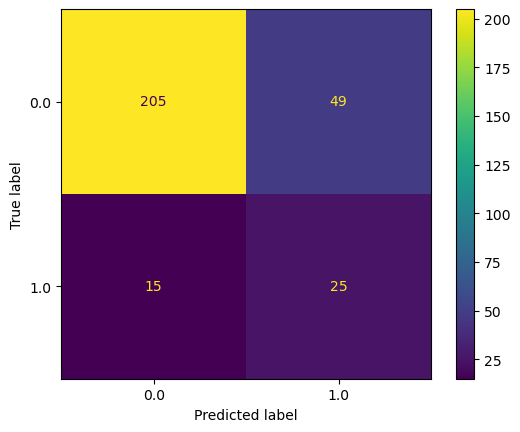

0.8335517693315858
0.625
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86       254
         1.0       0.34      0.62      0.44        40

    accuracy                           0.78       294
   macro avg       0.63      0.72      0.65       294
weighted avg       0.85      0.78      0.81       294

0.7751968503937008


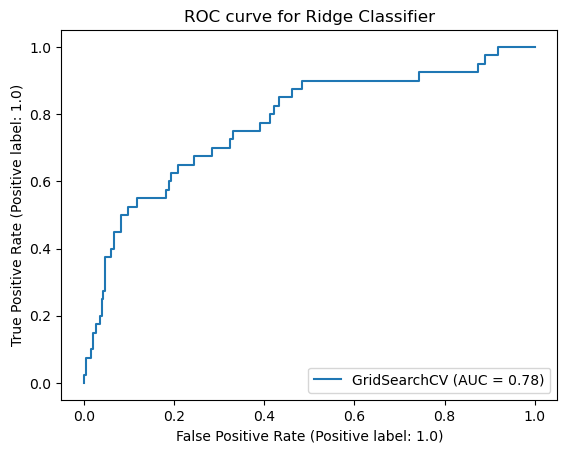

In [46]:
# Ridge Classifier
rc1 = GridSearchCV(RidgeClassifier(max_iter=1000),\
                    param_grid = { 'alpha': [0.01,0.05,0.06,0.07,0.08,0.09,0.1,0.15,0.2,0.5], \
                                  'solver':['auto', 'svd', 'cholesky'] },\
                    scoring = 'recall',\
                    verbose = 1,\
                    return_train_score = True ).fit(X_train,y_train) # F1 score is used in 'scoring' of GridSearchCV
print('-----------')
#print(rc1.cv_results_)
print('------------')
print(rc1.best_params_)

# Mean fit time
print(np.mean(rc1.cv_results_['mean_fit_time']))

ConfusionMatrixDisplay.from_estimator(rc1, X_test, y_test)
plt.show()

# recall-scores for train and test data
print(rc1.score(X_train,y_train))
print(rc1.score(X_test,y_test))
#Classification report for more information
print(classification_report(y_test, rc1.predict(X_test)))

#Besides F1 score, ROC AUC is also obtained as a performance metric
plot_roc_curve(rc1, X_test, y_test)
plt.title('ROC curve for Ridge Classifier')
print(roc_auc_score(y_test, rc1.decision_function(X_test))) 

# Recall is 63%, F1 is 44%
#ROC curve has an AUC=0.78, which shows a reasonably good performance

[ 0.05608189 -0.06736769 -0.08511008  0.09693521 -0.02683825 -0.01440195
 -0.13248228  0.02223928 -0.08153661 -0.15202763 -0.08902711  0.10973167
  0.02944033 -0.10422601  0.06493605 -0.04616083 -0.11975736 -0.05529386
 -0.03320489 -0.05895434  0.03217392  0.07499427  0.10998726 -0.09835538
  0.00255297  0.00639135  0.00194432  0.0228577   0.01144485 -0.09720673
  0.20147677  0.01575691 -0.04052687 -0.57087605 -0.11660267  0.63981144
  0.39085536  0.02157707  0.0248436   0.47334126  0.07624311  0.15076082
  0.02554446 -0.06464373]


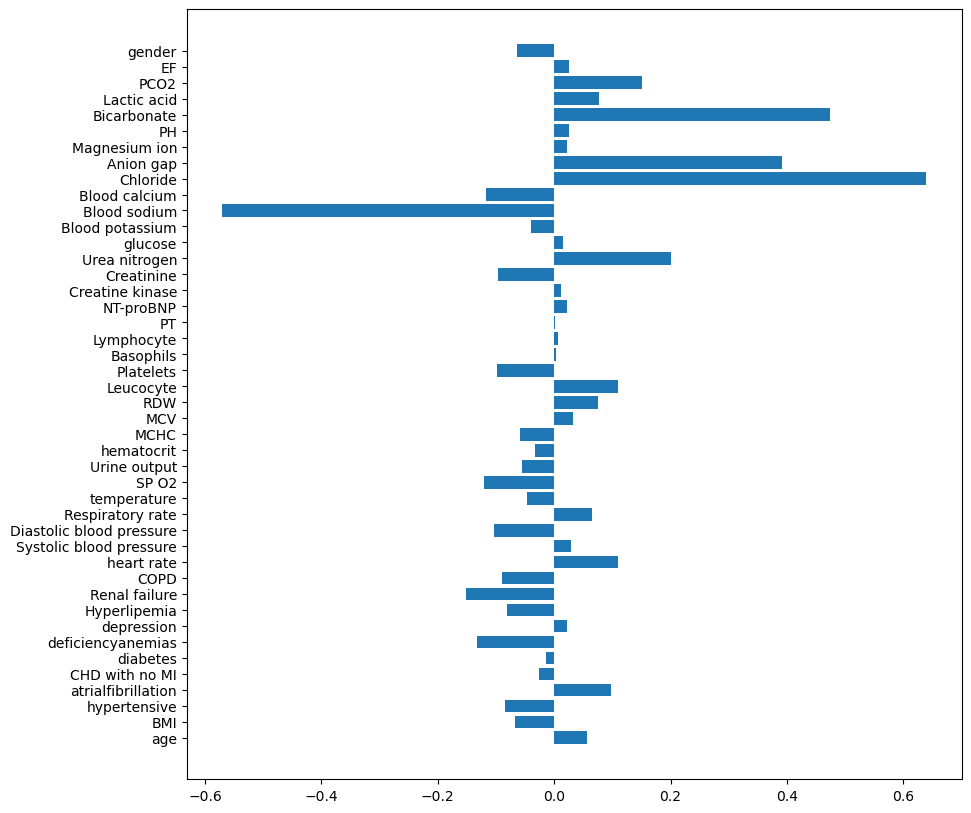

In [47]:
# From Ridge classifier, the top 5 variables that predict the survival/mortality of a patient in ICU are: 
# Chloride, Blood Sodium, Bicarbonate, Anion gap, and Urea nitrogen.
print(rc1.best_estimator_.coef_[0])
plt.figure(figsize=(10, 10))
plt.barh(X.columns,rc1.best_estimator_.coef_[0])
plt.show()

Fitting 5 folds for each of 192 candidates, totalling 960 fits
-----------
------------
{'C': 156.15230060004964, 'penalty': 'l2', 'solver': 'liblinear'}
0.05243200063705444


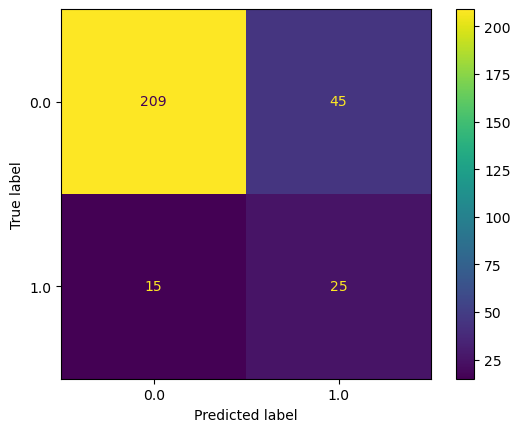

0.8309305373525557
0.625
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       254
         1.0       0.36      0.62      0.45        40

    accuracy                           0.80       294
   macro avg       0.65      0.72      0.66       294
weighted avg       0.85      0.80      0.82       294

0.7760826771653544


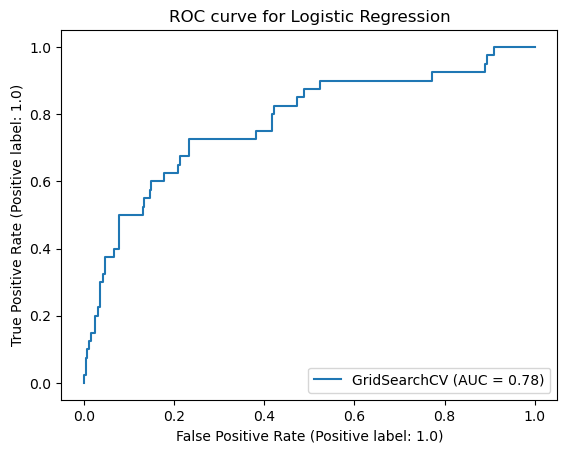

In [48]:
# Logistic Regression
log1 = GridSearchCV(LogisticRegression(max_iter=1000),\
                    param_grid = { 'penalty':['l1','l2'], 'C': np.logspace(-4,4,32), \
                                  'solver':['liblinear', 'lbfgs', 'newton-cg'] },\
                    scoring = 'recall',\
                    verbose = 1,\
                    return_train_score = True ).fit(X_train,y_train) # F1 score is used in 'scoring' of GridSearchCV
print('-----------')
#print(log1.cv_results_)
print('------------')
print(log1.best_params_)

# Mean fit time
print(np.mean(log1.cv_results_['mean_fit_time']))

ConfusionMatrixDisplay.from_estimator(log1, X_test, y_test)
plt.show()

# recall-scores for train and test data
print(log1.score(X_train,y_train))
print(log1.score(X_test,y_test))
#Classification report for more information
print(classification_report(y_test, log1.predict(X_test)))

#Besides F1 score, ROC AUC is also obtained as a performance metric
plot_roc_curve(log1, X_test, y_test)
plt.title('ROC curve for Logistic Regression')
print(roc_auc_score(y_test, log1.decision_function(X_test)))

# Recall is 63%, F1 is 45%
#ROC curve has an AUC=0.78, which shows a reasonably good performance

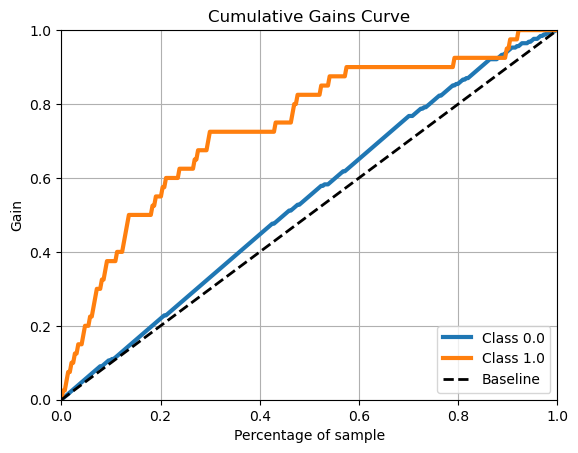

In [49]:
# Cumulative gains plot for logistic regression

# The curve shows for a given sampling % of patients, if the model will find more number of patients likely to not survie
# than random sampling (baseline).
# sampling 50% of the patients could get 80% patients likely to not survive (which is better than 
# random sampling, where sampling 50% of the patients could get 50% non-surviving patients)
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, log1.predict_proba(X_test))
plt.show()

[ 0.24867961 -0.33718744 -0.29276824  0.24587383 -0.10339565 -0.0588959
 -0.50377096  0.09635652 -0.25787638 -0.65751592 -0.41820859  0.33077117
  0.10675748 -0.47236964  0.23810739 -0.13565624 -0.50459291 -0.20854653
 -0.0720913  -0.27195347  0.16049986  0.27665649  0.4866229  -0.44446477
  0.01988508  0.02721942  0.02797918  0.00858974  0.04868039 -0.54964179
  0.87406704  0.04016094 -0.15317414 -1.80217442 -0.55481114  1.98834832
  1.55653756  0.10961508  0.04720037  1.64626085  0.28987801  0.42827597
  0.12453716 -0.22608885]


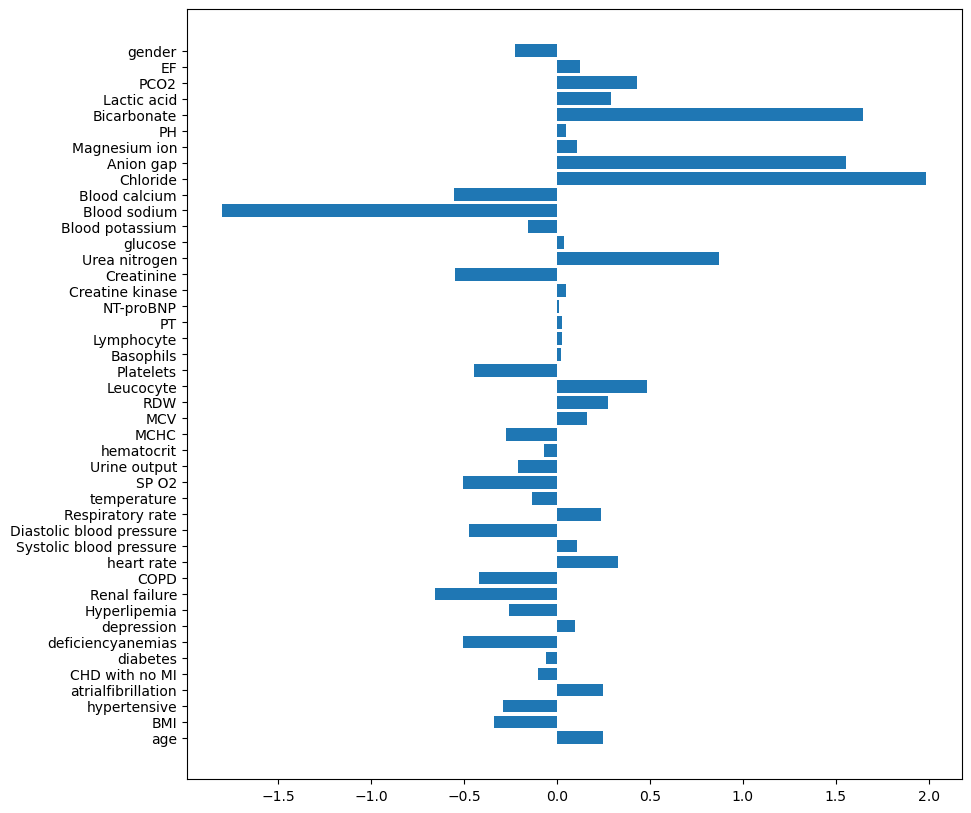

In [50]:
# Get Importance
importance = log1.best_estimator_.coef_[0]
print(importance)
# summarize feature importance
#for i,v in enumerate(importance):
 #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.figsize(10,10)
plt.figure(figsize=(10, 10))
plt.barh(X.columns, importance)
plt.show()

# From Logistic Regression, the top 5 variables that predict the survival/mortality of a patient in ICU are similar 
# to Ridge Classifier: 
# Chloride, Blood Sodium, Bicarbonate, Anion gap, and Urea nitrogen.

Hyperparameter tuning slightly imporved the performance of both Ridge and Logistic classification models with Recall of about 63% and F-1 score of 45% (improved by 1-2%). 

**Recommendations and Next Steps**

Feature importance reveals similar features from both models that predict mortality at ICU in the hospital and these are (top 5 in descending order of importance): 

-Chloride

-Blood Sodium

-Bicarbonate

-Anion gap

-Urea nitrogen


Next steps in the future could involve collecting additional data, imporving model fit and scores, and validating improved model on additional validation data. To improve computational efficiency, advanced packages like PyCaret could be used, and AutoML could be utilized. Deployment of the model should be done while keeping in mind the limitations of the model, and prioritizing patient care and efficient and careful utilization of ICU resources.